# Biodiversity Protection

This chart displays the mean proportion of Key Biodiversity Areas (KBAs) protected by country and by year. 

*Author: Rachel Thoms
<br>Created: 03 Sept 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Chart type: Pie chart

## Data

- Data: [ocn_024](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_024a_rw0_key_biodiversity_area_protection)
- Resource Watch: [unpublished](https://resourcewatch.org/data/explore/0b077461-6214-42dd-b9af-4ef4a0af70b9)
- Sources: 
    - KBAs - BirdLife International (MVP)
        - Requested tabular data was provided as a csv 
        - Metadata saved to [OneDrive](https://onewri.sharepoint.com/:w:/s/WRI_ocean/EUSUzvqUuI9AsfZbzd7hMi0B1CEi4mw8TkHuqvS4cWGMKQ?e=aIUebb)
    - *to be incorporated at a later date*: EBSAs - [Convention on Biological Diversity](https://www.cbd.int/ebsa/) via the [The Clearing-House Mechanism of the Convention on Biological Diversity (CHM)](https://chm.cbd.int/database)

## Data Processing

Data was uploaded for stoarge on Carto using a python script. See the script [here](https://github.com/rachelthoms/wri-projects/blob/main/ocean-watch/processing-scripts/biodiversity-protection/KBA/kba-processing.py).

## Vega Visualiztion

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 500
widget_height = 200

### Querying the data

#### Testing Version

```gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d'``` used as stand-in for parameterized ```gadm.{{geostore_env}}='{{geostore_id}}'``` in production version

```sql
SELECT gadm.gid_0, gadm.name_0, timeperiod, value FROM ocn_024a_rw0_key_biodiversity_area_protection AS data 
INNER JOIN ow_aliasing_countries AS alias ON alias.alias = data.geoareaname
INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0
WHERE gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d'
```

#### Parameterized Version

```sql
SELECT gadm.gid_0, gadm.name_0, timeperiod AS year, value FROM ocn_024a_rw0_key_biodiversity_area_protection AS data INNER JOIN ow_aliasing_countries AS alias ON alias.alias = data.geoareaname INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}'
```

### Resource Watch Widget Config

In [5]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "padding": 5,
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q= SELECT gadm.gid_0, gadm.name_0, timeperiod AS year, value FROM ocn_024a_rw0_key_biodiversity_area_protection AS data INNER JOIN ow_aliasing_countries AS alias ON alias.alias = data.geoareaname INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}'",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {"type": "filter", "expr": "datum.year === Year"},
        {
          "type": "formula",
          "expr": "format((100-datum.value), '.1f')",
          "as": "Unprotected"
        },
        {
          "type": "formula",
          "expr": "format(datum.value, '.1f')",
          "as": "Protected"
        },
        {"type": "fold", "fields": ["Protected", "Unprotected"], "as":["category","value"]},
        {
          "type": "formula",
          "expr": "datum.value/100",
          "as": "proportion"
        },
        {
          "type": "collect",
          "sort": {"field": ["category"], "order": ["descending"]}
        },
        {"type": "pie", "field": "value", "sort": false}
      ]
    }
  ],
  "signals": [
    {
      "name": "Year",
      "value": 2020,
      "bind": {"input": "range", "min": 2000, "max": 2020, "step": 1}
    },
    {
      "name": "active_value",
      "value": "",
      "on": [
        {"events": "*:mouseover", "update": "datum.value"},
        {"events": "*:mouseout", "update": "null"}
      ]
    },
    {
      "name": "active_key",
      "value": "",
      "on": [
        {"events": "*:mouseover", "update": "datum.category"},
        {"events": "*:mouseout", "update": "null"}
      ]
    }
  ],
  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "table", "field": "category"},
      "range": ["#e4e7eb", "#235487"]
    }
  ],
  "marks": [
    {
      "type": "arc",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "fill": {"scale": "color", "field": "category"},
          "x": {"signal": "width/ 2"},
          "y": {"signal": "height/ 2"}
        },
        "update": {
          "startAngle": {"field": "startAngle"},
          "endAngle": {"field": "endAngle"},
          "padAngle": {"value": 0},
          "innerRadius": {"value": 0},
          "outerRadius": {"signal": "width / 3"},
          "cornerRadius": {"value": 0},
          "stroke": {"value": "white"},
          "strokeWidth": {"value": 0},
          "fillOpacity": {"value": 1}
        },
        "hover": {
          "fillOpacity": {"value": 0.7},
          "zindex": {"value": 0}
        }
      }
    }
  ],
  "legends": [
    {
      "orient": "right",
      "type": "symbol",
      "fill": "color",
      "labelFontSize": 14,
      "labelFont": "Lato",
      "encode": {
        "labels": {
          "interactive": true, 
          "enter": {
            "fillOpacity": {"value": 1}
          },
          "update": {
            "fillOpacity": [{"test": "active_key === 'Protected' && datum.label != 'Protected' ","value": 0.1}, {"test": "active_key === 'Unprotected' && datum.label != 'Unprotected' ","value": 0.1}, {"value": 1}]
          }
        }
      }
    }
  ],
    "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "proportion",
            "property": "Average proportion of KBAs",
            "type": "number",
            "format": ".1%"
          }
        ]
      }
    }
  ]
}""")


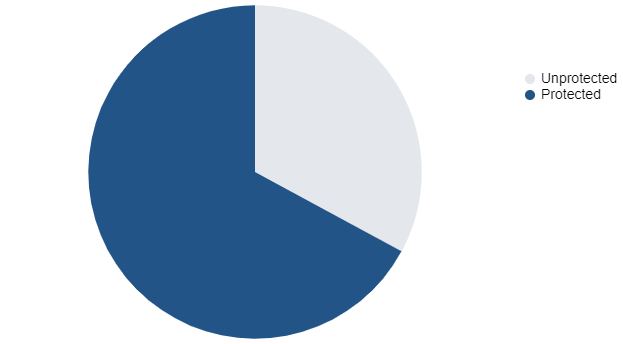

In [6]:
vega_view=dict(spec)
vega_view['width']= widget_width
vega_view['height']= widget_height
vega_view['legends'][0]['labelFont'] = 'Arial'
vega_view['data'][0]['url']= vega_view['data'][0]['url'].replace('{{geostore_env}}','geostore_prod')
vega_view['data'][0]['url'] = vega_view['data'][0]['url'].replace('{{geostore_id}}','ca5bfde08587530e76c17fe48362a01d')
Vega(vega_view)

[Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAB3GgBN6aAQAZVM+DTJY0AJnUycSBQpriyKmQqSYUqANqhxSBHDQg7TADbuZDACdvDyxcfCJZAJoAWgDZSigkAMw2BLYEAiQcGhI9TgBHbwB+fIBeAAIAZQBRABlqgGEAFXKKBQRqRQB9DVaTDpc3HqlyzBo3HDgotgVygEFK8oBPOCSR4iRvBjhygDEAJQB5AFlytihxHr0AFiQuuNUugGs4Ja6mdjNSAIg6N6TVl0cAE2Jg4FAxhJ5osbHZygBJAByiOq+3KAClDkizrIupsaEhfhYulA2AxxJgonAINDyvjCeVDoi6d4CRBKPSaRVYVQyHA2ACkIMdkiUWjMdi2ggAMwANh6fXajOZnNYYnKFSlnQUCoA6gAJVHVRUdPlsCApAJwIEg2bw2rwgDSxoA5IkBEwAGYKOCqAAcAj9AHYBNLVHAg7KoABGIOeuDXP1yvRIVTRhQu6QgT1sALITBoUCYJaTDyiCRZ4FsSbJJYeEGyCAgAC+MkpQogObzaCcnhL7nQnpo3jBASzcAAHsCPLCGB0VkkNaUKgBNVZj1tF-seLsIBjeFAySfTwe5-MACnP0fU0VnHQ2WzgAEoRi7KNHPS6n1nCR4AKriFWYIQnACgtlIW6lqeeb7oeIDHmO0EXnelAPtsr7vp+34yL+6AAAogsBYJgZufZQdmbDeGBMhDnAVFNo4IAEaC4LEVmAFAaxoEgAAuqRxbkaS3i+BCWZiMkhbZjQdFgYxLx1jxMi5j6iEOCAPrQHA4hmBYvHNvx27oNkfhSTJHhoSZ4kFqgnqbBAcDNnxikgL8ZAuN4DG9sKHhrkkWYWfoqgGDIHzaZJ5g4Aw1kgAEQp8lmCDmIFhggMgE6BcFLlgjgaDRvpEEgN56BIBCNCkF0AUyAF6BZhWjigHApAUgxIAAFSoAgZL2Ww3xZgwOCwgO6m2HOqGbNs4ENU1mAte1nUMN1UV9QNthDeI+7BI5pFFSAJVjOV8n+eNQ21ZI9XwdNs0dV1-K9f4K1gjOI0dIdpGNVpM0eHNN1kgW92DR463CS2TkyNAmzUj2ziuENQm5lmAlDcp5ibFmCjpEgSWoKAPIeF4vhZrRVEeK9MixRYA5qQAxAmEZwEwWZU6oACcfp+kg0p6c5yABE8nmQUNSRQITIIIJJuPoPj7itvB4ikj6kkfVMklDsD2MuYkBPoHDY40dJxPoKTIDperrnuR48hKDABDlHo4EgHWpvaOb6BaDomA23bMspJRYw5U7bmo+gwAunM3xIHy5RVjguaQuIZyeuUjqvOUABCnxlVMvzFvMVqEi6qDlChFnlAA1OULoAKQus2LYy-1AOm3YyRzBYWugETslZUkmCt2QBMy1pCh9+3pkG7Lw9t9LRgmCPA6gNVqgy+Y4hTPsJg0AtkmLzLv1rxvW8By7ciKPQ5Se-bpIBKvATr2Yh8L8daBL2DlJsC829P+gsgwHQ09ZSCF4upT4wE-o+Z+MtVbeEOMYKAfwwETVQHlGWMAerK3VlAmBJV4Hq0XpQIMMsABe5gfQm0fuA1AS99KORkL4Pk2l+YgFzNJCk9ZtC6DbIZFySwEBMEooTYcwRtaUXhrQpATA6K7AkNFOYURUZiIkd4KRFJKg0EIQOaM1wjxyxmPPEAB5FEMVAOYUce1M5oEpOhWWo4VaCKwXA4sCCNH5RAA3VatjhL2Jwb2MEFoPBmIOinZcFQXTMSIqBF05QABkUSi7PUoAYui5QACEISwlcQzOUI6FDVDvn4tSaKATrTySXCEjihEMmRJiXEzAo1EneBSWUwCFSQKZOyYg3JeUCrVTynxahfEgA)

# Indicator Value

Average proportion of biodiversity hotspots within protected areas

#### Formatted:
```sql
SELECT value FROM ocn_024a_rw0_key_biodiversity_area_protection 
INNER JOIN ow_aliasing_countries AS alias ON alias.alias = geoareaname
INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 
WHERE timeperiod = 2020 AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}'
```
#### Raw: 
`https://wri-rw.carto.com/api/v2/sql?q=SELECT ROUND(value) FROM ocn_024a_rw0_key_biodiversity_area_protection INNER JOIN ow_aliasing_countries AS alias ON alias.alias = geoareaname INNER JOIN gadm36_0 gadm ON alias.iso = gadm.gid_0 WHERE timeperiod = 2020 AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}'`

#### [Demo](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20ROUND(value)%20FROM%20ocn_024a_rw0_key_biodiversity_area_protection%20INNER%20JOIN%20ow_aliasing_countries%20AS%20alias%20ON%20alias.alias%20=%20geoareaname%20INNER%20JOIN%20gadm36_0%20gadm%20ON%20alias.iso%20=%20gadm.gid_0%20WHERE%20timeperiod%20=%202020%20AND%20geostore_prod%20ILIKE%20%27ca5bfde08587530e76c17fe48362a01d%27)


## RW Backoffice and API

#### Dataset
- dataset id: ```0b077461-6214-42dd-b9af-4ef4a0af70b9```
- parent dataset: [ocn_025](https://resourcewatch.org/data/explore/0b077461-6214-42dd-b9af-4ef4a0af70b9) 

#### Widget
- widget id: ```9c1482d4-b196-49c5-a558-f25467f6ae50```
- [API call](https://api.resourcewatch.org/v1/widget/9c1482d4-b196-49c5-a558-f25467f6ae50?env=production)
- [back office](https://resourcewatch.org/admin/data/widgets/9c1482d4-b196-49c5-a558-f25467f6ae50/edit?dataset=0b077461-6214-42dd-b9af-4ef4a0af70b9)